# 1. Setup and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import base64
import time
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from jiwer import wer

from google import genai                                    
from IPython.display import Audio, display, HTML, Markdown

In [2]:
load_dotenv('../.env')
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GEMINI_API_KEY:
    raise RuntimeError("GEMINI_API_KEY not found in .env.local")
else:
    print("GEMINI_API_KEY found in .env")


client = genai.Client(api_key=GEMINI_API_KEY)

GEMINI_2_5_FLASH_PREVIEW_05_20           = "gemini-2.5-flash-preview-05-20"
GEMINI_2_5_PRO_PREVIEW_06_05             = "gemini-2.5-pro-preview-06-05"
GEMINI_2_0_FLASH                         = "gemini-2.0-flash"
GEMINI_2_0_FLASH_EXPERIMENTAL            = "gemini-2.0-flash-exp"
GEMINI_2_0_FLASH_LITE                    = "gemini-2.0-flash-lite"
GEMINI_1_5_FLASH                         = "gemini-1.5-flash"
GEMINI_1_5_PRO                           = "gemini-1.5-pro"

GEMINI_API_KEY found in .env


In [3]:
BASE_URL = "audio_samples"
DOMAIN_MAP = {'telco': 'telecom'}

### 1.1 Helper Functions

In [4]:
def display_df(df: pd.DataFrame):
    html = df.head(300).to_html(index=False)

    scrollable = f'''
    <div style="
        max-height: 300px;
        max-width: 100%;
        overflow: auto;
        border: 1px solid #ccc;
        white-space: nowrap;
    ">
        {html}
    </div>
    '''

    display(HTML(scrollable))

In [5]:
def get_audio_and_path(df, idx):
    """
    Fetches the audio file from BASE_URL/<mapped_domain>/<AudioFile>,
    creates an IPython Audio player, and returns the Base64-encoded audio bytes.
    """
    # Ensure required columns exist
    if 'AudioFile' not in df.columns or 'Domain' not in df.columns:
        raise KeyError("DataFrame must contain both 'AudioFile' and 'Domain' columns")

    # Grab the raw domain and map it if needed
    raw_domain = df.at[idx, 'Domain']
    mapped_domain = DOMAIN_MAP.get(raw_domain, raw_domain)

    # Relative path to the audio file
    rel_path = df.at[idx, 'AudioFile']

    # Construct full path/URL
    full_path = f"{BASE_URL.rstrip('/')}/{mapped_domain}/{rel_path.lstrip('/')}"

    # Create the Audio player (URL or local file)
    if BASE_URL.startswith(("http://", "https://")):
        player = Audio(url=full_path)
    else:
        player = Audio(filename=full_path)

    # Read the audio bytes and Base64-encode
    with open(full_path, "rb") as f:
        audio_bytes = f.read()
    audio_base64 = base64.b64encode(audio_bytes).decode("utf-8")

    return player, full_path, audio_base64

In [6]:
def get_index_by_case_id(case_id, df: pd.DataFrame):
    idx = df.index[df['case_id'] == case_id]
    if not idx.empty:
        return idx[0]
    else:
        return None

In [7]:
def clean(t):
    # 1) strip tags + punctuation
    t = re.sub(r"\[.*?\]", "", t)
    t = re.sub(r"[^\w\s]", "", t)
    t = t.lower()
    # 2) drop filler/pronoun words
    t = re.sub(r"\b(po|ho|ah|um|eh|ko|mo)\b", "", t)
    # 3) collapse pag xxx → pagxxx
    t = re.sub(r"\bpag\s+(\w+)", r"pag\1", t)
    # 4) dedupe repeated words
    t = re.sub(r"\b(\w+)( \1)+\b", r"\1", t)
    # 5) normalize whitespace
    return re.sub(r"\s+", " ", t).strip()

# 2. Preparing the Data

In [8]:
df = pd.read_csv("synthetic_audio_bert.csv")
print("Shape: ", df.shape)
display_df(df)

Shape:  (779, 25)


case_id,case_text_value_type,case_text,case_source,case_type,case_transaction_type,case_status,case_priority_level,date_time_created,date_time_closed,customer_tier,RecordingId,SpeakerId,SegmentDuration,Domain,SampleRate,BitDepth,Role,IsNative,Age,Gender,Country,Accent,MainAudioFile,AudioFile
328659,Single message,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Phone,Deposits,Inquiry,New,Medium,2024-01-26T08:00:00+08:00,NaN,Mid,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:5.735,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328659.wav
328660,Single message,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:01:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:6.024,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328660.wav
328661,Single message,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:02:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:13.792,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328661.wav
328662,Single message,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:03:00+08:00,NaN,High,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:3.162,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328662.wav
328663,Single message,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",Phone,Deposits,Inquiry,New,Medium,2024-01-26T08:04:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:11.985,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328663.wav
328664,Single message,"Ang pangalan ko ay ""Doris Kelly""",Phone,Deposits,Request,New,High,2024-01-26T08:05:00+08:00,NaN,High,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:2.928,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328664.wav
328665,Single message,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Phone,Credit Cards,Inquiry,New,Low,2024-01-26T08:06:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:5.617,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328665.wav
328666,Single message,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,Phone,Deposits,Request,New,Low,2024-01-26T08:07:00+08:00,NaN,Mid,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:5.752,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328666.wav
328667,Single message,"Ang petsa ng aking kapanganakan ay [eng_start/] ""January"" twenty-seven nineteen eighty-six [eng_end/]",Ph

In [9]:
idx = get_index_by_case_id(330139, df)

sample_audio, sample_audio_url, sample_audio_base64 = get_audio_and_path(df, idx)
print((sample_audio_url))
sample_audio

audio_samples/banking/sliced_audio/banking_330139.wav


# 3. Transcription

In [10]:
def transcribe_audio(audio_b64, model):
    """
    Sends base64-encoded WAV audio to the model and returns the transcription as plain text.
    """
    audio_part = {
        "inlineData": {
            "mimeType": "audio/wav",
            "data": audio_b64
        }
    }
    text_part = {
        "text": (
            "You are a world-class transcription engine. "
            "Transcribe the following audio to plain text only, with no extra formatting:\n\n"
            "(Begin audio input)"
        )
    }

    resp = client.models.generate_content(
        model=model,
        contents=[audio_part, text_part]
    )
    return resp.text.strip()


In [11]:
transcription = transcribe_audio(sample_audio_base64, GEMINI_2_0_FLASH_EXPERIMENTAL)
print(f"Transcript:\n", transcription)

Transcript:
 Magandang araw. Ah, gusto ko lang sana mag-apply ng automobile loan.


# 4. Translation

In [12]:
def translate_to_english(text, model):
    """
    Detects the language of the input and translates it into English.
    """
    prompt = (
        "You are a world-class translation engine. "
        "Detect the language of the following text and translate it into English. "
        "Return ONLY the translated English text with no extra commentary:\n\n"
        f"{text}"
    )
    resp = client.models.generate_content(
        model=model,
        contents=prompt
    )
    return resp.text.strip()

In [13]:
translation = translate_to_english(transcription, GEMINI_2_0_FLASH_EXPERIMENTAL)
print("\nEnglish translation:\n", translation)


English translation:
 Good day. Ah, I would just like to apply for an automobile loan.


# 5. Evaluation

### 5.0 Reducing DataFrame to fit free tier standards

In [14]:
eval_df = df # df[:250]
eval_df.shape

(779, 25)

### 5.1 Evaluation Function

In [15]:
async def evaluate_gemini(df: pd.DataFrame, model: str, max_per_minute: int = 4) -> (pd.DataFrame, float):
    """
    Process each row of `df`, which must contain:
      - 'AudioFile'
      - 'Domain'
      - 'case_text' (Actual transcription)
    For each row, get audio, transcribe it, translate to English, clean texts, compute WER.
    Rate-limit to 4 rows per minute. Retry individual rows on error up to a max number of attempts.
    Returns a new DataFrame with columns:
      - AudioFile
      - Actual (original case_text)
      - Transcription
      - Translation
      - Cleaned Actual
      - Cleaned Transcription
      - WER
    Also returns the average WER.
    """
    # Prepare new DataFrame
    result_cols = [
        'AudioFile', 'Actual', 'Transcription', 'Translation',
        'Cleaned Actual', 'Cleaned Transcription', 'WER'
    ]
    results = pd.DataFrame(columns=result_cols)

    total_rows = len(df)
    window = time.monotonic()
    made = 0
    total_done = 0
    max_retries = 2
    retries = {}
    overlap_thresh = 0.8

    # TQDM progress bar per row
    progress = tqdm(total=total_rows, desc="Evaluating rows", unit="row", ncols=80)

    while total_done < total_rows:
        now = time.monotonic()
        # Rate-limit reset each 60 seconds
        if now - window >= 60:
            window = now
            made = 0
            tqdm.write("[rate-limit] reset window")

        if made >= max_per_minute:
            to_sleep = 60 - (now - window)
            if to_sleep > 0:
                tqdm.write(f"[rate-limit] sleeping {to_sleep:.1f}s")
                time.sleep(to_sleep)
            window = time.monotonic()
            made = 0
            tqdm.write("[rate-limit] resumed")

        # Process next row index
        idx = df.index[total_done]
        # Track retries for this row
        retries[idx] = retries.get(idx, 0)

        try:
            # 1) Fetch audio and path, encode
            _, _, audio_b64 = get_audio_and_path(df, idx)

            # 2) Transcribe
            transcription = transcribe_audio(audio_b64, model)

            # 3) Translate
            translation = translate_to_english(transcription, model)

            # 4) Clean actual and transcription
            actual = df.at[idx, 'case_text']
            cleaned_actual = clean(actual)
            cleaned_trans = clean(transcription)

            # 5) Compute WER
            if cleaned_actual in cleaned_trans or cleaned_trans in cleaned_actual:
                row_wer = 0.0
            else:
                # or if token‐overlap ≥ threshold
                ptoks = set(cleaned_trans.split())
                rtoks = set(cleaned_actual.split())
                if ptoks and len(ptoks & rtoks) / len(ptoks) >= overlap_thresh:
                    row_wer = 0.0
                else:
                    row_wer = wer(cleaned_actual, cleaned_trans)

            # 6) Append to results
            results.loc[len(results)] = [
                df.at[idx, 'AudioFile'],
                actual,
                transcription,
                translation,
                cleaned_actual,
                cleaned_trans,
                row_wer
            ]

            # Update counters
            total_done += 1
            made += 1
            progress.update(1)

        except Exception as e:
            retries[idx] += 1
            if retries[idx] <= max_retries:
                tqdm.write(f"[error] Row {idx} failed ({e}), retry {retries[idx]}/{max_retries}")
                # small backoff before retrying this row
                time.sleep(1)
                continue
            else:
                tqdm.write(f"[error] Row {idx} failed after {max_retries} retries, skipping.")
                # Skip this row entirely without appending
                total_done += 1
                made += 1
                progress.update(1)
                # Trigger potential rate-limit sleep in next iteration
                continue

    progress.close()

    # Compute average WER (ignoring None values)
    avg_wer = results['WER'].dropna().mean()

    return results, avg_wer

### 5.2 Gemini 1.5 Pro
- **RPM**: 1000
- **TPM**: 4,000,000
- **RPD**: -

In [16]:
GEMINI_1_5_PRO_df, GEMINI_1_5_PRO_wer = await evaluate_gemini(eval_df, GEMINI_1_5_PRO, 400)
print("Average Word Error Rate (WER):\n", GEMINI_1_5_PRO_wer)

display_df(GEMINI_1_5_PRO_df)

Evaluating rows:   0%|                                 | 0/779 [00:00<?, ?row/s]

[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
Average Word Error Rate (WER):
 0.2782

AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Maraming salamat sa pagtawag sa Bangko ng Makati. Ako po si Teresita. Ano pong puwedeng maitulong ko sa inyo?,Thank you for calling Bank of Makati. This is Teresita. How may I help you?,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong puwedeng maitulong sa inyo,0.000000
sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa resita, uhm, may tanong lang ako tungkol sa perang nalikom ko para sa kawang gawa.","At first, um, I just have a question about the money I collected for charity.",teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa resita uhm may tanong lang ako tungkol sa perang nalikom para sa kawang gawa,0.416667
sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ah, ganun ho ba? Sige ho. Ah, susubukan ko po kayong tulungan tungkol diyan. Ah, marami, ah, maaari ko po bang ma, matanong muna kung may account na po ba kayo sa bangko? Oo, mayroon naman na akong account sa inyong bangko.","Oh, is that so? Okay. I'll try to help you with that. Can I ask if you already have a bank account? Yes, I already have an account with your bank.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ganun ba sige susubukan kayong tulungan tungkol diyan marami maaari bang ma matanong muna kung may account na ba kayo sa bangko oo mayroon naman na akong account sa inyong bangko,0.523810
sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"Oo, meron naman akong account sa inyong banko.","Yes, I have an account at your bank.",oo meron naman na akong account sa inyong bangko,oo meron naman akong account sa inyong banko,0.000000
sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",Ah ganun po ba? Maaari ko po bang mahingi ang buo ninyong pangalan? Ang pangalan ko ay Doris Kelly. Maraming salamat po. Maaari ko rin po bang mahingi ang numero po ng national insurance,"Oh, is that so? May I have your full name, please? My name is Doris Kelly. Thank you very much. May I also have your national insurance number please?",ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,ganun ba maaari bang mahingi ang buo ninyong pangalan ang pangalan ay doris kelly maraming salamat maaari rin bang mahingi ang numero ng national insurance,0.000000
sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Doris Kelly.,My name is Doris Kelly.,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Ang numero ng aking National Insurance ay 13245698,My National Insurance number is 13245698,ang numero ng aking national insurance ay one three two four five six nine eight,ang numero ng aking national insurance ay 13245698,0.000000
sliced_audio/banking_328666.wav,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,Maraming salamat po. Maaari niyo rin po bang paki-verify 'ko sa akin ang petsa ng inyong kapanganakan?,Than

### 5.3 Gemini 1.5 Flash
- **RPM**: 2,000
- **TPM**: 4,000,000
- **RPD**: 1,000

In [17]:
GEMINI_1_5_FLASH_df, GEMINI_1_5_FLASH_wer = await evaluate_gemini(eval_df, GEMINI_1_5_FLASH, 900)
print("Average Word Error Rate (WER):\n", GEMINI_1_5_FLASH_wer)

display_df(GEMINI_1_5_FLASH_df)

Evaluating rows:   0%|                                 | 0/779 [00:00<?, ?row/s]

[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
Average Word Error Rate (WER):
 0.29440253207940076


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Maraming salamat sa pagtawag sa Bangko na Maalalahanin. Ako po si Teresita. Ano pong pwedeng maitutulong sa inyo?,Thank you for calling the Considerate Bank. This is Teresita. How may I help you?,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bangko na maalalahanin ako si teresita ano pong pwedeng maitutulong sa inyo,0.000000
sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa resita, uhm, may tanong lang ako tungkol sa perang nalikom ko para sa kawanggawa.","Regarding the receipt, uhm, I just have a question about the money I collected for charity.",teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa resita uhm may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,0.000000
sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ganun po ba? Sige po. Ah, susubukan ko po kayong tulungan tungkol diyan. Ah, marami—ah, maaari ko po bang ma—matatanong muna kung may account na po ba kayo sa bangko? Oo, meron naman na akong account sa inyong bangko.","Is that so? Okay. Ah, I will try to help you with that. Ah, many—ah, may I ask first if you already have an account with the bank? Yes, I already have an account with your bank.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ganun ba sige susubukan kayong tulungan tungkol diyan maramiah maaari bang mamatatanong muna kung may account na ba kayo sa bangko oo meron naman na akong account sa inyong bangko,0.571429
sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"O, meron naman akong account sa inyong bangko.","Oh, I have an account with your bank.",oo meron naman na akong account sa inyong bangko,o meron naman akong account sa inyong bangko,0.000000
sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]","Ah, ganoon po ba? Maaari ko po bang mahingi ang buo niyong pangalan? Ang pangalan ko ay Doris Kelly. Maraming salamat po. Maaari ko rin po bang mahingi ang numero po ng National Insurance?","Ah, is that so? May I have your full name, please? My name is Doris Kelly. Thank you very much. May I also have your National Insurance number, please?",ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,ganoon ba maaari bang mahingi ang buo niyong pangalan ang pangalan ay doris kelly maraming salamat maaari rin bang mahingi ang numero ng national insurance,0.380952
sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Doris Kelly.,My name is Doris Kelly.,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Ang numero ng aking National Insurance ay 13245698.,My National Insurance number is 13245698.,ang numero ng aking national insurance ay one three two four five six nine eight,ang numero ng aking national insurance ay 13245698,0.000000
sliced_audio/banking_328666.wav,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,Maraming salamat po. Maaari niyo rin po bang

### 5.4 Gemini 2.0 Flash-Lite
- **RPM**: 4,000
- **TPM**: 4,000,000
- **RPD**: -

In [18]:
GEMINI_2_0_FLASH_LITE_df, GEMINI_2_0_FLASH_LITE_wer = await evaluate_gemini(eval_df, GEMINI_2_0_FLASH_LITE, 1900)
print("Average Word Error Rate (WER):\n", GEMINI_2_0_FLASH_LITE_wer)

Evaluating rows:   0%|                                 | 0/779 [00:00<?, ?row/s]

[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
Average Word Error Rate (WER):
 0.6977988315878473


### 5.5 Gemini 2.0 Flash Experimental
- **RPM**: 10
- **TPM**: 4,000,000
- **RPD**: -

In [19]:
GEMINI_2_0_FLASH_EXPERIMENTAL_df, GEMINI_2_0_FLASH_EXPERIMENTAL_wer = await evaluate_gemini(eval_df, GEMINI_2_0_FLASH_EXPERIMENTAL, 4)
print("Average Word Error Rate (WER):\n", GEMINI_2_0_FLASH_EXPERIMENTAL_wer)

Evaluating rows:   0%|                                 | 0/779 [00:00<?, ?row/s]

[rate-limit] sleeping 49.5s
[rate-limit] resumed
[rate-limit] sleeping 50.9s
[rate-limit] resumed
[rate-limit] sleeping 48.1s
[rate-limit] resumed
[rate-limit] sleeping 46.2s
[rate-limit] resumed
[rate-limit] sleeping 49.2s
[rate-limit] resumed
[rate-limit] sleeping 49.7s
[rate-limit] resumed
[rate-limit] sleeping 49.2s
[rate-limit] resumed
[rate-limit] sleeping 50.1s
[rate-limit] resumed
[rate-limit] sleeping 48.9s
[rate-limit] resumed
[rate-limit] sleeping 43.0s
[rate-limit] resumed
[rate-limit] sleeping 49.8s
[rate-limit] resumed
[rate-limit] sleeping 50.2s
[rate-limit] resumed
[rate-limit] sleeping 48.1s
[rate-limit] resumed
[rate-limit] sleeping 40.8s
[rate-limit] resumed
[rate-limit] sleeping 25.9s
[rate-limit] resumed
[rate-limit] sleeping 46.2s
[rate-limit] resumed
[rate-limit] sleeping 48.6s
[rate-limit] resumed
[rate-limit] sleeping 49.2s
[rate-limit] resumed
[rate-limit] sleeping 47.1s
[rate-limit] resumed
[rate-limit] sleeping 30.7s
[rate-limit] resumed
[rate-limit] sleepin

### 5.6 Gemini 2.0 Flash
- **RPM**: 2,000
- **TPM**: 4,000,000
- **RPD**: -

In [20]:
GEMINI_2_0_FLASH_df, GEMINI_2_0_FLASH_wer = await evaluate_gemini(eval_df, GEMINI_2_0_FLASH, 1900)
print("Average Word Error Rate (WER):\n", GEMINI_2_0_FLASH_wer)

Evaluating rows:   0%|                                 | 0/779 [00:00<?, ?row/s]

[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
Average Word Error Rate (WER):
 0.3046146142033368


### 5.7 Gemini 2.5 Pro Preview 06-05
- **RPM**: 150
- **TPM**: 2,000,000
- **RPD**: 1,000

In [21]:
GEMINI_2_5_PRO_PREVIEW_06_05_df, GEMINI_2_5_PRO_PREVIEW_06_05_wer = await evaluate_gemini(eval_df[:400], GEMINI_2_5_PRO_PREVIEW_06_05, 400)
print("Average Word Error Rate (WER):\n", GEMINI_2_5_PRO_PREVIEW_06_05_wer)

Evaluating rows:   0%|                                 | 0/400 [00:00<?, ?row/s]

[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit]

### 5.9 Gemini 2.5 Flash Preview 05-20
- **RPM**: 1,000
- **TPM**: 1,000,000
- **RPD**: 10,000

In [22]:
GEMINI_2_5_FLASH_PREVIEW_05_20_df, GEMINI_2_5_FLASH_PREVIEW_05_20_wer = await evaluate_gemini(eval_df, GEMINI_2_5_FLASH_PREVIEW_05_20, 400)
print("Average Word Error Rate (WER):\n", GEMINI_2_5_FLASH_PREVIEW_05_20_wer)

Evaluating rows:   0%|                                 | 0/779 [00:00<?, ?row/s]

[rate-limit] reset window
[error] Row 19 failed ('NoneType' object has no attribute 'strip'), retry 1/2
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[error] Row 107 failed ('NoneType' object has no attribute 'strip'), retry 1/2
[error] Row 107 failed ('NoneType' object has no attribute 'strip'), retry 2/2
[error] Row 107 failed after 2 retries, skipping.
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[rate-limit] reset window
[error] Row 253 failed ('NoneType' object has no attribute 'strip'), retry 1/2
[error] Row 253 failed ('NoneType' object has no attribute 'strip'), retry 2/2
[error] Ro

# 6. Analysis and Insights

In [24]:
models = [
    "Gemini 1.5 Pro",
    "Gemini 1.5 Flash",
    "Gemini 2.0 Flash-Lite",
    "Gemini 2.0 Flash Experimental",
    "Gemini 2.0 Flash",
    "Gemini 2.5 Pro Preview 06-05",
    "Gemini 2.5 Flash Preview 05-20"
]
wers = [
    GEMINI_1_5_PRO_wer,
    GEMINI_1_5_FLASH_wer,
    GEMINI_2_0_FLASH_LITE_wer,
    GEMINI_2_0_FLASH_EXPERIMENTAL_wer,
    GEMINI_2_0_FLASH_wer,
    GEMINI_2_5_PRO_PREVIEW_06_05_wer,
    GEMINI_2_5_FLASH_PREVIEW_05_20_wer
]

dfs = [
    GEMINI_1_5_PRO_df,
    GEMINI_1_5_FLASH_df,
    GEMINI_2_0_FLASH_LITE_df,
    GEMINI_2_0_FLASH_EXPERIMENTAL_df,
    GEMINI_2_0_FLASH_df,
    GEMINI_2_5_PRO_PREVIEW_06_05_df,
    GEMINI_2_5_FLASH_PREVIEW_05_20_df
]

### 6.1 Word Error Rate Comparisons

C:\Users\dariu\AppData\Local\Temp\ipykernel_39476\1314293773.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(models, rotation=45, ha="right", fontsize=10)
C:\Users\dariu\AppData\Local\Temp\ipykernel_39476\1314293773.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models, rotation=45, ha="right", fontsize=10)


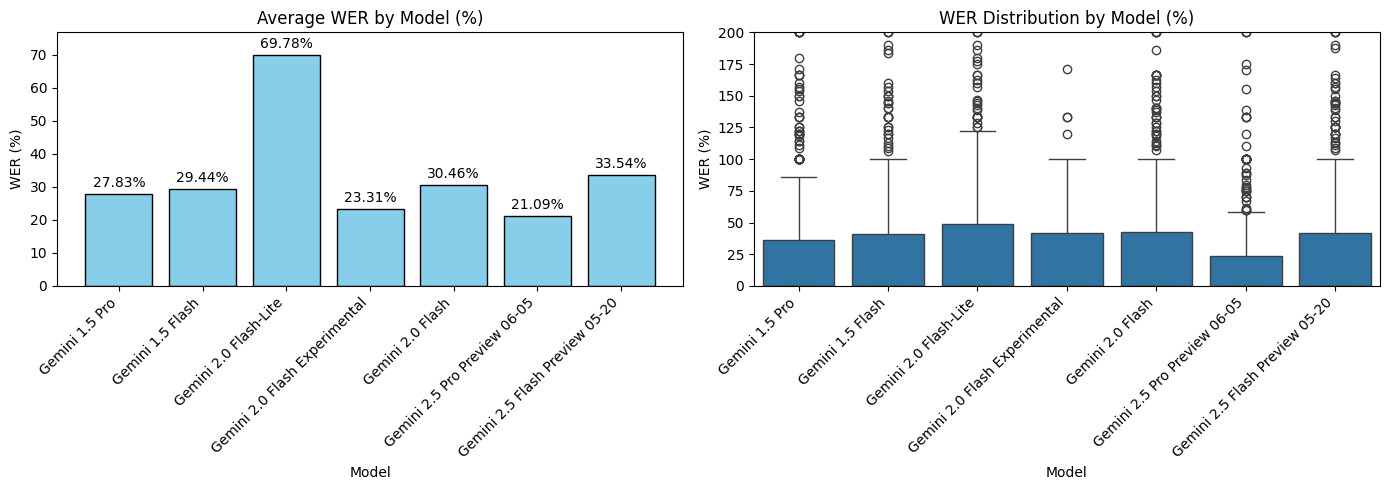

In [31]:
wers_pct = [w * 100 for w in wers]

# Build a “long” DataFrame for the box‐plot. 
# Each row in all_wers corresponds to one example from one model’s evaluation.
all_wers = pd.concat([
    pd.DataFrame({
        "model": m,
        "wer_pct": df["WER"] * 100
    })
    for m, df in zip(
        models,
        dfs
    )
], ignore_index=True)

# Plot side‐by‐side: (a) bar chart of average WER, (b) box‐plot of WER distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of average WER (%)
bars = axes[0].bar(models, wers_pct, color="skyblue", edgecolor="black")
axes[0].set_title("Average WER by Model (%)")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("WER (%)")
axes[0].set_ylim(0, max(wers_pct) * 1.1)

# Annotate each bar with its percentage
for bar in bars:
    h = bar.get_height()
    axes[0].annotate(
        f"{h:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Box‐plot of the WER distribution (percentage) per model
sns.boxplot(
    x="model",
    y="wer_pct",
    data=all_wers,
    order=models,
    ax=axes[1]
)
axes[1].set_title("WER Distribution by Model (%)")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("WER (%)")

axes[1].set_ylim(0, 200)

# Rotate and right‐align long names
axes[0].set_xticklabels(models, rotation=45, ha="right", fontsize=10)
axes[1].set_xticklabels(models, rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()

### 6.2 Sample Text Comparisons

In [32]:
def display_text_comparisons_split(sample_idxs, dfs, models):
    """
    Display two styled tables:
    1. Transcription comparison only
    2. Translation comparison only

    Args:
        sample_idxs: list of row indices to display
        dfs: list of DataFrames
        models: list of model names corresponding to dfs
    """
    # Build columns for transcriptions
    trans_cols = pd.MultiIndex.from_tuples(
        [("Reference", "")] + [(m, "Transcription") for m in models]
    )
    # Build columns for translations
    transl_cols = pd.MultiIndex.from_tuples(
        [("Reference", "")] + [(m, "Translation") for m in models]
    )

    # Prepare data rows
    trans_data = []
    transl_data = []
    for idx in sample_idxs:
        # Reference uses "Cleaned Actual"
        ref = dfs[0].loc[idx, "Cleaned Actual"]
        trans_row = [ref] + [df.loc[idx, "Cleaned Transcription"] for df in dfs]
        transl_row = [ref] + [df.loc[idx, "Translation"] for df in dfs]
        trans_data.append(trans_row)
        transl_data.append(transl_row)

    trans_df = pd.DataFrame(trans_data, index=[f"Sample {i}" for i in sample_idxs], columns=trans_cols)
    transl_df = pd.DataFrame(transl_data, index=[f"Sample {i}" for i in sample_idxs], columns=transl_cols)

    # Common styling
    table_style = [
        {"selector": "th",     "props": [("font-family", "monospace"),
                                         ("background-color", "#333"),
                                         ("color", "white"),
                                         ("padding", "8px")]},
        {"selector": "td",     "props": [("font-family", "monospace"),
                                         ("padding", "8px"),
                                         ("color", "#222") ]},
        {"selector": "tbody tr:nth-child(odd)", "props": [("background-color", "#f9f9f9")]},
        {"selector": "tbody tr:nth-child(even)","props": [("background-color", "white")]},
    ]

    # Display transcription table
    trans_styled = (trans_df.style
        .set_table_styles(table_style)
        .set_properties(**{"white-space": "pre-wrap", "text-align": "left"})
        .set_caption("Transcription Comparison Across Models"))
    display(trans_styled)

    # Display translation table
    transl_styled = (transl_df.style
        .set_table_styles(table_style)
        .set_properties(**{"white-space": "pre-wrap", "text-align": "left"})
        .set_caption("Translation Comparison Across Models"))
    display(transl_styled)

In [ ]:
# Choose whichever row indices you want to inspect
sample_idxs = [0, 10, 42, 60, 65]

# Call the existing function with these new arguments
display_text_comparisons_split(sample_idxs, dfs, models)

,Reference,Gemini 1.5 Pro,Gemini 1.5 Flash,Gemini 2.0 Flash-Lite,Gemini 2.0 Flash Experimental,Gemini 2.0 Flash,Gemini 2.5 Pro Preview 06-05,Gemini 2.5 Flash Preview 05-20
,,Transcription,Transcription,Transcription,Transcription,Transcription,Transcription,Transcription
Sample 0,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong puwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bangko na maalalahanin ako si teresita ano pong pwedeng maitutulong sa inyo,sa ngalan ng salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pweding maitulong sa inyo,magandang araw salamat sa pagtawag sa banko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,magandang araw maraming salamat sa pagtawag sa banko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,magandang salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwede kong maitulong sa inyo
Sample 10,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema,mm masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yon sa bank account nang walang anumang problema,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account ng walang anumang problema,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account ng walang anumang problema,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema hmm,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yon sa bank account nang walang anumang problema,masyado kasing madaming pera ang nadonate noong charity run itatanong lang sana kung maari bang ilagay yon sa bank account ng walang anumang problema
Sample 42,naintindihan pwede na ra min tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,naiintindihan pwede na rin tayong pumili sa ibat ibang klase ng media pwede rin na gumagamit tayo ng email,naintindihan pwede na rin tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,naiintindihan pwede na rin tayong pumili sa ibatibang klase ng media pwede rin na gumamit tayo ng email,naiintindihan pwede na rin tayong pumili sa ibatibang klase ng media pwede rin na gumamit tayo ng email,naiintindihan pwede na namin tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,naintindihan pwede na rin tayong pumili sa ibatibang klase ng media pwede rin na gumamit tayo ng email,naiintindihan pwede na rin tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email
Sample 60,sandali pwede bang ulitin yung huli mong sinabi,sandali uh pwede bang ulitin yung huli mong sinabi,sandali puwede bang ulitin yung huli mong sinabi,sandali pwede bang ulitin yung huli mong sinabi,sandali pwede bang ulitin yung huli mong sinabi,sandali uh pwede bang ulitin yung huli mong sinabi,sandali pwede bang ulitin yung huli mong sinabi,sandali uh pwede bang ulitin yung huli mong sinabi
Sample 65,ayun salamat sa inyong oras meron pa kayong opo meron pa ba akong maitutulong sa inyo,ayun salamat sa inyong oras meron pa kayong opo meron pa ba akong maitutulong sa inyo,ayun salamat sa inyong oras meron pa kayongopo meron pa ba akong maitutulong sa inyo,ayoon salamat sa inyong oras meron pa ba kayong oopo meron pa ba akong maitutulong sa inyo,ayun salamat sa inyong oras meron ka

,Reference,Gemini 1.5 Pro,Gemini 1.5 Flash,Gemini 2.0 Flash-Lite,Gemini 2.0 Flash Experimental,Gemini 2.0 Flash,Gemini 2.5 Pro Preview 06-05,Gemini 2.5 Flash Preview 05-20
,,Translation,Translation,Translation,Translation,Translation,Translation,Translation
Sample 0,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,Thank you for calling Bank of Makati. This is Teresita. How may I help you?,Thank you for calling the Considerate Bank. This is Teresita. How may I help you?,Thank you for calling Makati Bank. This is Teresita. How may I help you?,"Good day, thank you for calling Makati Bank. This is Teresita. How may I help you?","Good day, thank you for calling Makati Bank, my name is Teresita, how may I help you?",Thank you for calling the Bank of Makati. My name is Teresita. How can I help you?,Thank you for calling the Bank of Makati. This is Teresita. How may I help you?
Sample 10,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema,There's just too much money donated during the charity run. I was just wondering if I could put it in a bank account without any problems.,There was too much money donated during the charity run. I just wanted to ask if I could deposit it in the bank account without any problems.,There was too much money donated during the charity run. I was just wondering if I could put that in the bank account without any problems?,There was too much money donated during the charity run. I just wanted to ask if I could put that in a bank account without any problems.,There was too much money donated during the charity run. I was just wondering if I could put that in the bank account without any problems? Hmm.,A lot of money was donated during the charity run. I just wanted to ask if I can deposit it into a bank account without any problems?,Too much money was donated during the charity run. I was just wondering if I could deposit it into the bank account without any issues.
Sample 42,naintindihan pwede na ra min tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,"I understand. Uh, we can also choose from different uh kinds of media. We can also use email.","Ah, I understand. Ah, we can also choose from different kinds of media. We can also use email.","Ah, I understand. Ah, we can also choose from different kinds of media. We can also use email.","Ah, I understand. Ah, we can also choose from different kinds of media, we can also use email.","Ah, I understand. Ah, we can now choose from different kinds of media. We can also use email.","Ah, I understand. We can also choose from different kinds of media. We can also use email.","Ah, I understand. We can also choose from various types of media. We can also use email."
Sample 60,sandali pwede bang ulitin yung huli mong sinabi,"Wait, uh, could you repeat what you just said?","Excuse me, could you repeat what you just said?","""Excuse me, could you repeat what you just said?""","Wait, um, could you repeat what you said last?","Wait, uh, can you repeat what you said last?","Wait. Ah, can you repeat the last thing you said?","Wait, uh, could you repeat what you just said?"
Sample 65,ayun salamat sa inyong oras meron pa kayong opo meron pa ba akong maitutulong sa inyo,Okay. Thank you for your time. Do you have anything else...? Yes. Is there anything else I can help you with?,"Yes. Ah, thank you for your time. Ah, you still have—yes. Is there anything else I can help you with?","Yes, po. Thank you for your time. Do you have anything else, yes. Is there anything else I can help you with?","Okay. Thank you for your time. Do you have anything, oh yes. Is there anything else I can help you with? Thank you.","Okay, thank you for your time. Ah do you have Ah yes. Is there anything else I can help you with? Thank you.",Alright then. Thank you for your time. Is there anything else I can help you with?,"Al